# Sequências - Aula Prática 03/04
## RNNs (Recurrent Neural Networks)

Neste notebook iremos continuar nossos estudos de redes neurais recorrentes (RNNs), trabalhando dessa vez com modelos `seq2seq` (*sequence-to-sequence*) para construir um tradutor de francês para inglês, uma ideia simples mas poderosa onde duas RNNs trabalham em conjunto para transformar uma sequência em outra.

![](../imagens/seq2seq.png)

- Esse notebook foi fortemente inspirado no terceiro tutorial da série [NLP From Scratch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), disponibilizado no site do PyTorch.

Se você estiver rodando esse notebook na Tatu, execute a seguinte célula de código.

In [20]:
%load_ext nbproxy


Variáveis de ambiente http_proxy e https_proxy configuradas!


Instalando pacotes necessários para realizarmos manipulações e outras operações com texto.

In [21]:
!pip install nltk
!pip install unidecode

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for Unidecode from https://files.pythonhosted.org/packages/84/b7/6ec57841fb67c98f52fc8e4a2d96df60059637cba077edc569a302a8ffc7/Unidecode-1.3.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.8 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


## Importação de pacotes

In [93]:
import re
import torch
import random

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from unidecode import unidecode
from torch.utils.data import Dataset, DataLoader

In [2]:
# Verificando se temos CUDA disponível e selecionando o device que será utilizado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device escolhido:', device)

Device escolhido: cuda


## Entendimento da base de dados

A base de dados trabalhada durante esse notebook consiste em um arquivo `.txt` que possui pares de frases tanto em inglês quanto em francês, separados por um *tab*.

In [3]:
!head /pgeoprj/ciag2023/datasets/sequence_datasets/seq2seq/eng-fra.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


## Processamento da base de dados

De maneira similar à codificação feita em notebooks anteriores, iremos representar cada palavra de uma linguagem como sendo um índice numérico. Como iremos trabalhar com mais de uma linguagem, é natural criarmos uma classe, denominada de `Language`, para conter os dicionários que irão mapear *tokens* para índices (`token2index`) e índices para *tokens* (`index2token`).A

Além disso, manteremos um terceiro dicionário chamado de `token_counter` para manter salvo a frequência de cada *token* nos dados daquela linguagem. Futuramente, iremos utilizar essa frequência para filtrar entradas que contém *tokens* raros, reduzindo assim a gigantesca base de dados para termos algo que executa de forma mais rápida, o que indiretamente também facilita o treinamento da nossa rede.

> Note que nesse notebook nós faremos o uso dos *tokens* especiais: **\<pad\>**, **\<sos\>** e **\<eos\>**, definindo de forma manual os índices relacionados com cada *token*.

In [92]:
PAD_INDEX = 0
SOS_INDEX = 1
EOS_INDEX = 2

class Language:
    def __init__(self, name):
        self.name = name
        self.token2index = {}
        self.token_counter = {}
        self.index2token = {PAD_INDEX: '<pad>', SOS_INDEX: '<sos>', EOS_INDEX: '<eos>'}
        self.n_tokens = 3  # variável para associar um índice com um novo token

    def add_sentence(self, sentence):
        for token in sentence.split(' '):
            self.add_token(token)

    def add_token(self, token):
        if token not in self.token2index:
            self.token_counter[token] = 1
            self.token2index[token] = self.n_tokens
            self.index2token[self.n_tokens] = token
            self.n_tokens += 1
        else:
            self.token_counter[token] += 1

    def trim(self, threshold):        
        keep_tokens = []
        
        for token, count in self.token_counter.items():
            if count >= threshold:
                keep_tokens.append(token)

        ratio = len(keep_tokens) / len(self.token2index)
        print(f'Razão de tokens mantidos: {ratio:.4f}')

        # Reinicializando dicionários
        self.token2index = {}
        self.token2count = {}
        self.index2token = {PAD_INDEX: '<pad>', SOS_INDEX: '<sos>', EOS_INDEX: '<eos>'}
        self.n_tokens = 3

        for token in keep_tokens:
            self.add_token(token)

Os textos do arquivo estão todos em [Unicode](https://pt.wikipedia.org/wiki/Unicode). Para simplificar o dado, iremos converter todos os caracteres Unicode em [ASCII](https://pt.wikipedia.org/wiki/ASCII), tornando tudo em caixa baixa e removendo boa parte dos sinais diacríticos através da função `preprocess_string`.

> O módulo `re` é para aproveitarmos do poder de utilizar *expressões regulares*, ou do inglês *regular expressions*, permitindo realizar casamento e processamento de *strings* rapidamente. 

In [72]:
def preprocess_string(string):
    ascii = unidecode(string).lower().strip()
    ascii = re.sub(r"([.!?])", r" \1", ascii)  # colocando um espaço entre texto e pontuação
    ascii = re.sub(r"[^a-zA-Z.!?]+", r" ", ascii)  # removendo tudo que não é um token válido
    ascii = ascii.strip()

    return ascii

# Exemplos de uso do preprocess_string
print(preprocess_string('kožušček'))
print(preprocess_string('François'))
print(preprocess_string("J'ai froid."))

kozuscek
bei jing
francois
j ai froid .


Para ler os dados do arquivo `.txt`, nós iremos separar o conteúdo em linhas e depois cada linha em pares `(frase1, frase2)`. Como vimos anteriormente, as frases estão separadas por *tab* (`\t`), onde a primeira frase está em inglês e a segunda em francês. Já que queremos fazer uma tradução no sentido francês $\rightarrow$ inglês, iremos salvar os pares na ordem inversa, mantendo uma ideia de `(entrada, saída)`.

In [95]:
def build_pairs():
    with open('/pgeoprj/ciag2023/datasets/sequence_datasets/seq2seq/eng-fra.txt', 'r') as fp:
        lines = fp.readlines()

    pairs = []
    for line in lines:
        sentence1, sentence2 = line.split('\t')
        pairs.append((preprocess_string(sentence2), preprocess_string(sentence1)))

    return pairs

pairs = build_pairs()
print('Número de pares:', len(pairs))
print('Exemplo dos primeiros 3 pares:', pairs[:3])

Número de pares: 135842
Exemplo dos primeiros 3 pares: [('va !', 'go .'), ('cours !', 'run !'), ('courez !', 'run !')]


Como temos muitos exemplos de frases, e queremos treinar algo relativamente rápido, iremos reduzir o número de sentenças e usar apenas entradas relativamente simples e curtas, com no máximo 10 palavras (incluindo a pontuação final). Além disso, iremos trabalhar apenas com entradas que traduzem para algo do tipo "*I am*", "*He is*", etc. Tudo isso será condensado na função `filter_pair`.

In [117]:
MAX_LENGTH = 10

eng_prefixes = (
    'i am ', 'i m ',
    'he is', 'he s ',
    'she is', 'she s ',
    'you are', 'you re ',
    'we are', 'we re ',
    'they are', 'they re '
)

def filter_pair(pair):
    text1_length = len(pair[0].split(' '))
    text2_length = len(pair[1].split(' '))

    return text1_length < MAX_LENGTH and text2_length < MAX_LENGTH and pair[1].startswith(eng_prefixes)

pairs = list(filter(filter_pair, pairs))
print('Novo número de pares:', len(pairs))
print('Exemplo dos três primeiros novos pares:', pairs[:3])

Novo número de pares: 10601
Exemplo dos três primeiros novos pares: [('j ai ans .', 'i m .'), ('je vais bien .', 'i m ok .'), ('ca va .', 'i m ok .')]


Finalmente, iremos criar o escopo de cada linguagem que iremos trabalhar.

In [118]:
def build_languages(pairs):
    input_language = Language('eng')
    output_language = Language('fra')

    for sentence1, sentence2 in pairs:
        input_language.add_sentence(sentence1)
        output_language.add_sentence(sentence2)

    return input_language, output_language

input_language, output_language = build_languages(pairs)
print(f'Número de tokens para linguagem {input_language.name}: {input_language.n_tokens}')
print(f'Número de tokens para linguagem {output_language.name}: {output_language.n_tokens}')
print('Exemplo aleatório de um par:', random.choice(pairs))

Número de tokens para linguagem eng: 4350
Número de tokens para linguagem fra: 2805
Exemplo aleatório de um par: ('nous essayons .', 'we re trying .')


## Construção de um `Dataset` e `DataLoader`

Finalmente, iremos estudar uma forma de agrupar sequências de tamanhos diferentes em um único *batch* de dados, permitindo trabalhar com `batch_size` em modelos recorrentes.

Para isso, faremos um uso extensivo do módulo `torch.nn.utils.rnn`, ou `rnn_utils` como definimos nos imports no começo desse notebook. A partir desse módulo, conseguimos aplicar *padding* em um conjunto de sequências através da função `pad_sequence`, uniformizando o tamanho das sequências. Além disso, PyTorch disponibiliza um tipo específico de dados chamado de `PackedSequence`, destinado exclusivamente para modelos recorrentes, onde podemos usar as funções `pack_padded_sequence` e `pad_packed_sequence`, para converter de tensores para `PackedSequences` e vice-versa.

> **Importante:** O uso de `PackedSequences` é interessante quando trabalhamos com dados de tamanho variável, uma vez que os modelos do PyTorch conseguem efetivamente "pular" *tokens* `<pad>`, poupando memória e computação!

Como estamos trabalhando com sequências de tamanho variável, precisamos "ensinar" para o PyTorch como que iremos "colar" todas essas sequências para formar um único *batch*. Isso será feito através da definição de uma função chamada `collate_fn` (algo como função de combinação), onde nela usaremos a função `pad_sequence` para conseguir construir um *batch* de dados sem problemas.

- Por ora não iremos nos preocupar com a separação entre conjuntos de treino, validação e teste. O objetivo desse notebook é de ensinar como trabalhamos em cenários `seq2seq`, além de como utilizar modelos mais complexos como GRUs e LSTMs.

In [132]:
def collate_fn(batch):
    input_tensors = []
    output_tensors = []

    for input_tensor, output_tensor in batch:
        input_tensors.append(input_tensor)
        output_tensors.append(output_tensor)

    input_tensors = rnn_utils.pad_sequence(input_tensors, batch_first=False, padding_value=PAD_INDEX)
    output_tensors = rnn_utils.pad_sequence(output_tensors, batch_first=False, padding_value=PAD_INDEX)
    
    return input_tensors, output_tensors

class TranslationDataset(Dataset):
    def __init__(self):
        pairs = build_pairs()
        self.pairs = list(filter(filter_pair, pairs))
        self.input_language, self.output_language = build_languages(self.pairs)
    
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_sentence, output_sentence = self.pairs[idx]

        input_tensor = self.sentence2tensor(input_sentence)
        output_tensor = self.sentence2tensor(output_sentence, is_input=False)
        
        return input_tensor, output_tensor
    
    def sentence2tensor(self, sentence, is_input = True):
        tokens = sentence.split(' ')
        tensor = torch.zeros(len(tokens) + 2, dtype=torch.long)  # +2 para comportar <sos> e <eos>

        tensor[0] = SOS_INDEX
        tensor[-1] = EOS_INDEX

        language = self.input_language if is_input else self.output_language
        for idx, token in enumerate(tokens):
            tensor[idx+1] = language.token2index[token]

        return tensor

    def tensor2sentence(self, tensor, is_input = True):
        language = self.input_language if is_input else self.output_language
        return ' '.join(language.index2token[idx.item()] for idx in tensor)

Exemplo de uma amostra do `TranslationDataset`.

In [133]:
dataset = TranslationDataset()
input_tensor, output_tensor = dataset[42]

print('Tensor de entrada:', input_tensor)
print('Tensor de saída:', output_tensor)

print('\nFrase de entrada:', dataset.tensor2sentence(input_tensor))
print('Frase de saída:', dataset.tensor2sentence(output_tensor, is_input=False))

Tensor de entrada: tensor([ 1,  3, 15, 12, 51,  6,  2])
Tensor de saída: tensor([ 1,  3,  4, 34,  5,  2])

Frase de entrada: <sos> j en suis certain . <eos>
Frase de saída: <sos> i m sure . <eos>


Exemplo de uma amostra do nosso `DataLoader`.

In [149]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

input_tensor, output_tensor = next(iter(dataloader))
print('Tamanho da entrada e saída:', (input_tensor.shape, output_tensor.shape))

Tamanho da entrada e saída: (torch.Size([11, 32]), torch.Size([11, 32]))


In [150]:
first_input = input_tensor[:, 0]
first_output = output_tensor[:, 0]

print('Tensor de entrada:', first_input)
print('Tensor de saída:', first_output)

print('\nFrase de entrada:', dataset.tensor2sentence(first_input))
print('Frase de saída:', dataset.tensor2sentence(first_output, is_input=False))

Tensor de entrada: tensor([  1, 119, 215, 322, 628,  18,   2,   0,   0,   0,   0])
Tensor de saída: tensor([   1,  130,  125,  654,   43, 1582,    5,    2,    0,    0,    0])

Frase de entrada: <sos> vous etes tellement adorable ! <eos> <pad> <pad> <pad> <pad>
Frase de saída: <sos> you are such a sweetheart . <eos> <pad> <pad> <pad>


## Modelo *seq2seq*

Seguindo as ideias trabalhadas em notebooks passados, precisamos criar um mapeamento entre *tokens* e índices. No nosso caso, o *token* é uma letra do nosso alfabeto. Para isso, iremos construir nosso alfabeto (vocabulário), com base nas letras únicas de todos os nomes da base de dados, e, posteriormente, iremos criar 2 estruturas para realizar tal mapeamento: `token2index` e `index2token`.

> Além dos *tokens* obtidos através do texto, é muito comum vermos também outros 3 *tokens* especiais:
> - **\<sos\>**: abreviação para *start-of-sequence*, ou início de sentença.
> - **\<eos\>**: abreviação para *end-of-sequence*, ou fim de sentença.
> - **\<pad\>**: *token* especial destinado para indicar um valor de *pad* na nossa sequência.

- Diferentemente do notebook anterior, os *tokens* de **\<sos\>** e **\<eos\>** serão úteis, uma vez que eles são utilizados em contextos de geração de sentenças. O token **\<pad\>** ainda não será utilizado, uma vez que ainda não trabalharemos com *batches* por enquanto.
  - Na verdade, iremos utilizar apenas o *token* **\<eos\>** no nosso vocabulário, já que forneceremos a primeira letra do nome que queremos gerar para o nosso modelo. Ao utilizar o *token* **\<sos\>** no nosso contexto, a nossa rede terá que adivinhar às cegas o primeiro *token* do nosso nome. A utilização de ambos *tokens* de início e fim de sentença são mais vistos em abordagens *seq2seq*, onde produzimos um contexto da frase de entrada, auxiliando a rede a prever o *token* inicial a partir de **\<sos\>** com mais garantia de acerto.

In [6]:
vocabulary = []

# Adicionando o token especial <eos>
vocabulary.append('<eos>')

for names in language_names.values():
    for name in names:
        for token in name:        
            if token not in vocabulary:
                vocabulary.append(token)

print('Tamanho do alfabeto:', len(vocabulary))
print('5 tokens aleatórios do alfabeto:', random.choices(vocabulary, k=5))

Tamanho do alfabeto: 83
5 tokens aleatórios do alfabeto: ['t', 'ò', 'G', 'Ś', 'C']


In [7]:
index2token = []
token2index = {}

for token_idx, token in enumerate(vocabulary):
    index2token.append(token)
    token2index[token] = token_idx

print('Token de índice 42:', index2token[42])
print('Índice do token "<eos>":', token2index['<eos>'])

Token de índice 42: p
Índice do token "<eos>": 0


Agora que temos as estruturas `index2token` e `token2index` bem definidas, conseguimos converter um nome em um tensor de índices numéricos através das funções `token2tensor` e `name2tensor`, como demonstrado a seguir.

> **Observação 1:** Criaremos um tensor de tamanho $n \times 1$, onde $n$ é o tamanho do nome e $1$ o tamanho do nosso *batch*. Para esse notebook, nós não iremos trabalhar com `batch_size > 1`, devido à complicações relacionadas com manipulação de sequências e *padding*. Deixaremos tais assuntos para serem abordados no notebook de `seq2seq`.

- Optamos por trocar a ordem padrão das dimensões dos dados em PyTorch, ou seja, com o tamanho do *batch* no começo, para facilitar operações em sequências no futuro, como utilizar `len` para obter o tamanho da sequência e tornar a indexação mais fácil. Na verdade, especificamente para sequências, PyTorch nos dá a opção de colocar o tamanho do *batch* como primeira dimensão do nosso tensor ou na segunda, sendo a primeira o tamanho da nossa sequência. Veremos isso em mais detalhes quando trabalharmos com os modelos recorrentes implementados pelo PyTorch.

In [8]:
def token2tensor(token):
    return torch.tensor([token2index[token]], dtype=torch.long)

def name2tensor(name):
    tensor = torch.zeros((1 + len(name), 1), dtype=torch.long)
    
    # Adicionando os tokens de fim de sentença
    tensor[-1] = token2tensor('<eos>')
    
    for idx, token in enumerate(name):
        tensor[idx] = token2tensor(token)

    return tensor

name = 'Jonas'
print(f'Tensor para o token J:', token2tensor('J'))
print(f'Tensor para o nome {name}: {name2tensor(name).T}')  # transposição para fins de print

Tensor para o token J: tensor([50])
Tensor para o nome Jonas: tensor([[50,  3, 25,  8,  9,  0]])


Para finalizar essa parte do notebook sobre dados, iremos criar uma função auxiliar `get_random_pair` para selecionar de forma aleatória um par `(idioma, nome)` da nossa base dados. Além disso, tal função irá retornar os tensores relacionados com cada componente do par.

- Por ora não iremos nos preocupar com a separação entre conjuntos de treino, validação e teste. O objetivo desse notebook é de ensinar como trabalhamos do zero com geração de sequências.

In [9]:
def language2tensor(language):
    return torch.tensor([languages.index(language)], dtype=torch.long)

def get_random_pair():
    language = random.choice(languages)
    name = random.choice(language_names[language])
    name = ''.join(name)  # convertendo lista de caracteres em string

    name_tensor = name2tensor(name)
    language_tensor = language2tensor(language)

    return name, language, name_tensor, language_tensor

In [10]:
name, language, name_tensor, language_tensor = get_random_pair()

print('Par selecionado:', (name, language))
print('Tensores do par:', (name_tensor.T, language_tensor))

Par selecionado: ('Jon', 'Korean')
Tensores do par: (tensor([[50,  3, 25,  0]]), tensor([9]))


## Definição do nosso modelo

Como já tratamos a implementação de uma RNN do zero no notebook anterior, iremos utilizar o módulo `nn.RNN` disponibilizado pelo PyTorch. Uma documentação mais extensiva desse módulo pode ser encontrada [aqui](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#rnn). Não iremos utilizar todos os parâmetros customizáveis do módulo, mas iremos explicar eles aqui brevemente.

- **`input_size`**: o número de *features* da entrada, no nosso caso por exemplo o tamanho da dimensão de *embedding*.
- **`hidden_size`**: o tamanho do estado oculto ($h$) que utilizaremos.
- **`num_layers`**: número de camadas recorrentes que iremos "empilhar".
- **`nonlinearity`**: a camada de ativação não linear utilizado ao longo da recorrência.
- **`bias`**: valor *booleano* indicando se queremos ou não utilizar viés nas camadas.
- **`batch_first`**: valor *booleano* que permite a gente indicar se queremos trabalhar com dados onde a primeira dimensão é o tamanho do *batch*, nesse caso `batch_first=True`, ou o tamanho da sequência.
- **`dropout`**: introduz *dropout* em cada saída da camada recorrente (usado com `num_layers != 1`).
- **`bidirectional`**: valor *booleano* que indica se queremos um modelo recorrente bidirecional.

Logo abaixo temos um exemplo de utilização do módulo `nn.RNN`. Suponha que após aplicarmos o embedding, nós tenhamos a matriz `X`, cujas dimensões são: $S \times 1 \times E$, onde $S$ é o tamanho da sequência e $E$ o tamanho do embedding escolhido.

> Para esse exemplo utilizamos: $S = 4$, $E = 2$, $h = 8$.

In [11]:
seq_length = 4
embedding_size = 2
X = torch.rand(seq_length, 1, embedding_size)  # definindo uma matriz X aleatória apenas para exemplo

hidden_size = 8
model = nn.RNN(embedding_size, hidden_size, batch_first=False)

hidden = None  # nn.RNN irá selecionar h0 como sendo zeros
for Xt in X:
    outputs, hidden = model(Xt, hidden)

print('Tamanho do output final:', outputs.shape)
print('Tamanho do hidden final:', hidden.shape)

Tamanho do output final: torch.Size([1, 8])
Tamanho do hidden final: torch.Size([1, 8])


Como iremos trabalhar com geração de texto, **condicionando** a geração de nomes a partir de um idioma específico, a entrada do nosso modelo no tempo $t$ será a concatenação do *embedding* do *token* atual com o do idioma selecionado. Para isso, teremos dois *embeddings* diferentes: um para a transformação do idioma; e outro para transformação do *token*.

Um diagrama do esquema de geração pode ser visto a seguir, note que a nossa arquitetura possui uma modelagem autorregressiva, ou seja, a predição do tempo o $t$ depende das predições do tempo $t-1$, e assim por diante. Nele, o símbolo `&` representa o operador de concatenação das entradas.

> A geração da sentença será finalizada quando o modelo prever um *token* de fim de sentença ou quando atingirmos um tamanho predeterminado, forçando assim a adição de um `<eos>` no final da predição.

![](../imagens/rnn_autorregressivo.png)

In [12]:
class NameGenerationModel(nn.Module):
    def __init__(self, vocab_size, num_languages, embedding_size, hidden_size):
        super().__init__()

        self.letter_embedding = nn.Embedding(vocab_size, embedding_size)
        self.language_embedding = nn.Embedding(num_languages, embedding_size)

        self.rnn = nn.RNN(2 * embedding_size, hidden_size, batch_first=False)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x, language, hidden = None):
        x = self.letter_embedding(x)
        language = self.language_embedding(language)
        combined = torch.cat([x, language], dim=-1)  # iremos concatenar ao longo das features

        output, hidden = self.rnn(combined, hidden)
        output = self.classifier(output)

        return output, hidden

Exemplo da utilização da rede para o tempo $t = 0$.

In [13]:
token = 'J'
language = 'English'

token_tensor = token2tensor(token)
language_tensor = language2tensor(language)

model = NameGenerationModel(len(vocabulary), len(languages), embedding_size=16, hidden_size=32)
output, hidden = model(token_tensor, language_tensor)

print('Saída do modelo:', output)
print('\nEstado oculto:', hidden)

next_token = output.argmax()
print('\nPróximo token previsto:', index2token[next_token])

Saída do modelo: tensor([[-4.3127, -4.3729, -4.6023, -5.1198, -4.2001, -4.0599, -4.4466, -4.4725,
         -4.4736, -4.1429, -4.3761, -4.0316, -4.5924, -4.5246, -4.8090, -4.5005,
         -4.9784, -4.6526, -3.8958, -4.1140, -4.4725, -4.4878, -4.8589, -4.9187,
         -4.3690, -4.7872, -4.0835, -4.5726, -4.0561, -4.8965, -4.3949, -4.7226,
         -4.4075, -4.5168, -4.6556, -4.1843, -4.2750, -4.4151, -4.5997, -4.1011,
         -4.5208, -4.2276, -4.0197, -4.1403, -4.3222, -4.4085, -4.5460, -4.0449,
         -4.0477, -4.8675, -4.6912, -4.3057, -4.4953, -4.7843, -4.7493, -4.5717,
         -4.5224, -4.4328, -4.3288, -3.9806, -4.5949, -4.6525, -4.2889, -4.1353,
         -4.6397, -4.7143, -4.5830, -4.8833, -4.7111, -4.4183, -4.2231, -4.3145,
         -4.4207, -4.9036, -3.9180, -4.8810, -4.3709, -4.8032, -4.2959, -4.1839,
         -4.6930, -4.2591, -4.5415]], grad_fn=<LogSoftmaxBackward0>)

Estado oculto: tensor([[-0.6726, -0.6069,  0.0560,  0.5762, -0.1705, -0.7336, -0.2788,  0.4740,
       

## Treinamento do modelo

Para o treinamento do modelo generativo, iremos introduzir um novo conceito conhecido como *teacher forcing*, uma estratégia de treinamento de geração de sequências para acelerar a convergência do modelo e garantir estabilidade ao longo do treinamento. A estratégia consiste em utilizar como entrada para o tempo $t$ o *token* real do tempo $t-1$ ao invés da predição do modelo.

À primeira vista, essa estratégia pode parecer "roubada". Porém, temos que lembrar que o predição do modelo no tempo $t$ é dada pelo *ground truth* do tempo $t-1$ e o estado oculto do modelo que foi atualizado utilizando os *ground truths* do tempo $1$ até $t-2$. Ou seja, o modelo ainda está aprendendo os padrões linguísticos da sentença que lhe foi apresentada, mesmo não usando as suas próprias predições. Uma analogia interessante que podemos fazer com *teacher forcing* é quando vamos fazer uma prova onde a questão **d)** depende da resposta correta da questão **c)** e assim por diante. Se errarmos a questão **a)**, estaremos correndo o risco de errar todas as questões seguintes, mesmo realizando os cálculos corretos. Porém, se no começo de cada questão nós começarmos com a resposta correta da anterior, conseguimos acertar algumas coisas.

> **Importante:** Durante a geração de sentenças fora do treino, utilizaremos as predições do modelo ao invés do *ground truth* da sentença, uma vez que tal informação não está disponível. Sendo assim, é esperado observar uma discrepância da performance do modelo. Isso é conhecido na literatura como *exposure bias*, e uma forma simples de mitigar esse efeito é de utilizar *teacher forcing* de maneira probabilística, reduzindo a probabilidade de uso a medida que o modelo prevê novos *tokens* da sentença. Outra estratégia interessante pode ser lida no seguinte [artigo](https://arxiv.org/pdf/2103.11603.pdf), onde os autores propõem fornecer para o modelo um conjunto de palavras similares à do passo $t-1$ ao invés de um único *ground truth*.

- Apenas para relembrar: Como o nosso modelo recorrente possui como última camada uma `LogSoftmax`, iremos utilizar a função de perda `nn.NLLLoss` (*negative log-likelihood*), que espera log-probabilidades como saída da rede. Um fato curioso é que `nn.CrossEntropyLoss = LogSoftmax + nn.NLLLoss`, segundo a própria [documentação](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) da `nn.CrossEntropyLoss`.

In [14]:
model = NameGenerationModel(len(vocabulary), len(languages), embedding_size=64, hidden_size=128)
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

loss_interval = 1000  # intervalo para salvar a loss média
print_interval = 5000  # intervalo para exibir performance da rede
num_iterations = 100000

# Variáveis para manter o valor da loss ao longo das épocas
all_losses = []
average_loss = 0

Algo a se notar aqui é que ao invés de usarmos a última saída da rede para calcular a função de custo, como no caso da classificação de nomes, estaremos realizando uma predição a cada instante de tempo. Logo, precisaremos calcular a função de custo para cada predição.

Para lidar com isso, o `autograd` do PyTorch permite você apenas somar todos os valores das funções de custo em cada instante de tempo e depois chamar `.backward()` no fim.

In [15]:
for iter in tqdm(range(1, num_iterations + 1)):
    name, language, name_tensor, language_tensor = get_random_pair()
    
    name_tensor = name_tensor.to(device)
    language_tensor = language_tensor.to(device)

    loss = 0
    hidden = None
    predicted_tokens = [name[0]]  # o primeiro token é informado a priori

    # Iremos iterar sobre todos os tokens até o penúltimo
    for idx in range(len(name_tensor) - 1):
        output, hidden = model.forward(name_tensor[idx], language_tensor, hidden)  # note que estamos sempre fazendo teacher forcing
        loss += criterion(output, name_tensor[idx+1])

        # Salvando o nome predito pelo modelo
        token = index2token[output.argmax()]
        if token != '<eos>':
            predicted_tokens.append(token)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    average_loss +=  loss.item() / (len(name_tensor) - 1)
    
    if iter % print_interval == 0:
        predicted_name = ''.join(predicted_tokens)  # convertendo de lista de caracteres para string

        print(f'Iter [{iter}/{num_iterations}] => loss: {loss:.5f}, ' \
              f'input {language, name}, predicted name: {predicted_name}')
        
    if iter % loss_interval == 0:
        all_losses.append(average_loss / loss_interval)
        average_loss = 0

  0%|          | 0/100000 [00:00<?, ?it/s]

Iter [5000/100000] => loss: 9.15676, input ('Dutch', 'Peij'), predicted name: Perne
Iter [10000/100000] => loss: 14.03139, input ('Spanish', 'Noguerra'), predicted name: Neneera
Iter [15000/100000] => loss: 4.55933, input ('Korean', 'Nam'), predicted name: Ngn
Iter [20000/100000] => loss: 8.72096, input ('Polish', 'Bosko'), predicted name: Buwkaw
Iter [25000/100000] => loss: 5.04007, input ('Scottish', 'Hay'), predicted name: Hun
Iter [30000/100000] => loss: 7.21501, input ('Arabic', 'Deeb'), predicted name: Darr
Iter [35000/100000] => loss: 8.76673, input ('German', 'Reiter'), predicted name: Rosser
Iter [40000/100000] => loss: 9.02612, input ('Scottish', 'Milne'), predicted name: Mclle
Iter [45000/100000] => loss: 5.42725, input ('French', 'Sauvage'), predicted name: Sauvager
Iter [50000/100000] => loss: 7.22971, input ('French', 'Harman'), predicted name: Harrin
Iter [55000/100000] => loss: 12.83179, input ('Dutch', 'Haanraats'), predicted name: Heandand
Iter [60000/100000] => loss:

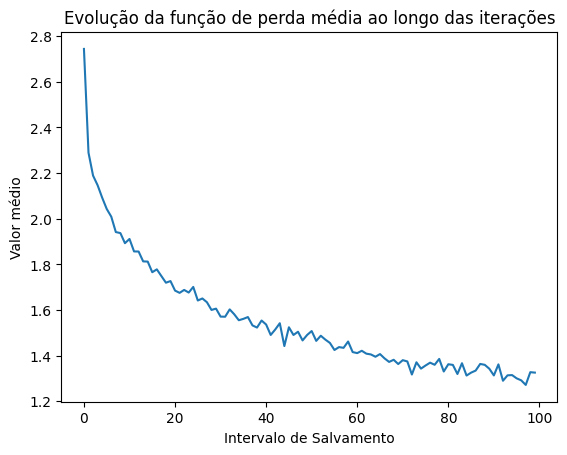

In [16]:
plt.title('Evolução da função de perda média ao longo das iterações')
plt.xlabel('Intervalo de Salvamento')
plt.ylabel('Valor médio')
    
plt.plot(all_losses)
plt.show()

## Gerando novos nomes

Para gerar um novo nome (processo de *sampling*), iremos definir uma função `sample` que, dado um idioma e uma letra inicial, faz com que a rede gere um nome até prever o *token* `<eos>`, ou atingir um tamanho máximo de sentença (nesse caso 20). Nesse caso, usaremos a previsão da rede do tempo $t-1$ para realizar a previsão do tempo $t$.

> Teremos a função auxiliar `samples` para realizar múltiplas amostragens da rede dado: um idioma, quais *tokens* iniciais queremos para cada nome e uma função de amostragem.

In [17]:
max_length = 20

def sample(language, token):
    model.eval()

    with torch.no_grad():
        hidden = None 
        generated_name = token
        language_tensor = language2tensor(language).to(device)

        for i in range(max_length):
            token_tensor = token2tensor(token).to(device)

            output, hidden = model(token_tensor, language_tensor, hidden)
            token = index2token[output.argmax()]

            if token == '<eos>':
                break

            generated_name += token

        return generated_name
    
def samples(language, start_tokens, sampling_fn):
    print(f'\n{language}:')
    for token in start_tokens:
        print(' >', sampling_fn(language, token))

In [18]:
samples('Spanish', 'SPA', sample)
samples('Russian', 'RUS', sample)
samples('Chinese', 'CHI', sample)


Spanish:
 > Santiago
 > Parez
 > Arino

Russian:
 > Rahilov
 > Ustelan
 > Shakhin

Chinese:
 > Chang
 > Huan
 > Ing


Perceba que se executarmos a geração com os mesmos *tokens* iniciais, teremos os mesmos nomes. Isso se deve ao fato de estarmos utilizando uma estratégia de *sampling* determinística, ou seja, escolhendo o próximo *token* como sendo sempre aquele que tem maior probabilidade de ocorrer. Como os pesos da nossa rede estão fixados, sempre teremos os mesmos nomes sendo gerados. 

In [19]:
samples('Spanish', 'SSS', sample)
samples('Russian', 'RRR', sample)
samples('Chinese', 'CCC', sample)


Spanish:
 > Santiago
 > Santiago
 > Santiago

Russian:
 > Rahilov
 > Rahilov
 > Rahilov

Chinese:
 > Chang
 > Chang
 > Chang


Para modificar esse comportamento, teremos que introduzir algum viés probabilístico no processo de geração. Existem uma diversidade de estratégias que podemos escolher para introduzir esse viés, como por exemplo:

1. Adicionar um ruído na entrada do modelo, alterando um pouco o *embedding* inicial.
2. Selecionar os **top-k** *tokens* mais prováveis e realizar uma amostragem desse conjunto.
3. Reponderar as probabilidades associadas com cada *token* e realizar uma amostragem com base nessa nova probabilidade (*Temperature Sampling*).

Visando simplicidade de implementação e robustez, iremos implementar a segunda estratégia, nomeada de **Top-k Sampling**.

In [20]:
def topk_sampling(language, token, k=5):
    model.eval()

    with torch.no_grad():
        hidden = None 
        generated_name = token
        language_tensor = language2tensor(language).to(device)

        for i in range(max_length):
            token_tensor = token2tensor(token).to(device)
            output, hidden = model(token_tensor, language_tensor, hidden)

            # Obtendo as top-k predições da rede
            vals, idxs = torch.topk(output[0], k=k)
            vals = vals.detach().cpu().numpy()  # covertendo para numpy
            idxs = idxs.detach().cpu().numpy()  # convertendo para numpy
            
            probs = np.e ** vals
            probs = probs / probs.sum()

            idx = np.random.choice(idxs, p=probs)
            token = index2token[idx]
            
            if token == '<eos>':
                break

            generated_name += token

        return generated_name

In [21]:
samples('Spanish', 'SSS', topk_sampling)
samples('Russian', 'RRR', topk_sampling)
samples('Chinese', 'CCC', topk_sampling)


Spanish:
 > Soana
 > Sieti
 > Soto

Russian:
 > Rotulail
 > Raisanev
 > Reinkhenkov

Chinese:
 > Chian
 > Chin
 > Chi
